In [79]:
# import dependencies
import pandas as pd
import tensorflow as tf

In [80]:
# initialize spark
import findspark
findspark.init()

In [81]:
# import dependencies
from pyspark.sql import SparkSession
from pyspark import SparkFiles
import sklearn as skl

In [82]:
# initialize spark session
spark = SparkSession.builder.appName('SparkSQL').getOrCreate()

In [83]:
# use spark to read in csv to dataframe
spark.sparkContext.addFile('games_metadata_profile_2024_01.csv')
df = spark.read.csv(SparkFiles.get('games_metadata_profile_2024_01.csv'), header=True, inferSchema= True)

In [84]:
# create temporary view / table to use for queries
df.createOrReplaceTempView('chess')

In [85]:
# view dataframe
df.show()

+------+-----------------+-----+--------------------+----------+-------------------+---------------+--------+---------------+----------------+------------------+------------------+-----------------+--------------------+---------------+-----------+--------------------+--------+---------------+----------------+------------------+------------------+-----------------+--------------------+---------------+-----------+--------------------+----------+---+--------------------+-----------+------------+-------+
|GameID|            Event|Round|                Site|      Date|               Time|          White|WhiteElo|WhiteRatingDiff|White_is_deleted|White_tosViolation|White_profile_flag|  White_createdAt|White_playTime_total|White_count_all|White_title|               Black|BlackElo|BlackRatingDiff|Black_is_deleted|Black_tosViolation|Black_profile_flag|  Black_createdAt|Black_playTime_total|Black_count_all|Black_title|               Moves|TotalMoves|ECO|             Opening|TimeControl| Terminati

In [86]:
# select relevant columns of data and save as pandas dataframe
data = spark.sql(
    '''
SELECT WhiteElo, White_playTime_total, White_count_all, BlackElo, Black_playTime_total, Black_count_all, TotalMoves,
Result from chess
WHERE Result != '*'
'''
).toPandas()

In [87]:
# drop null values
data.dropna(inplace=True)

In [88]:
# create features exploring the differences in white versus black to use in prediction model
data['Rating Difference'] = data['WhiteElo'] - data['BlackElo']
data['Playtime Difference'] = data['White_playTime_total'] - data['Black_playTime_total']
data['Games Played Difference'] = data['White_count_all'] - data['Black_count_all']
data['White Average Playtime'] = data['White_playTime_total']/data['White_count_all']
data['Black Average Playtime'] = data['Black_playTime_total']/data['Black_count_all']
data['Average Playtime Difference'] = data['White Average Playtime'] - data['Black Average Playtime']

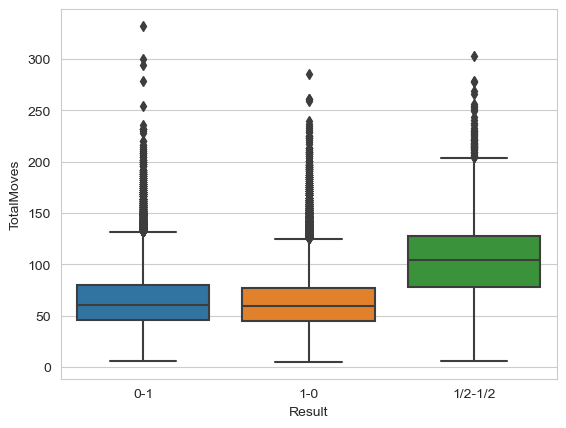

In [89]:
# create boxplot to explore difference between white and black victories with regard to total moves made
import seaborn as sns
sns.set_style("whitegrid")
tips = sns.load_dataset("tips")
ax = sns.boxplot(x=data['Result'], y=data['TotalMoves'])

(-10000000.0, 10000000.0)

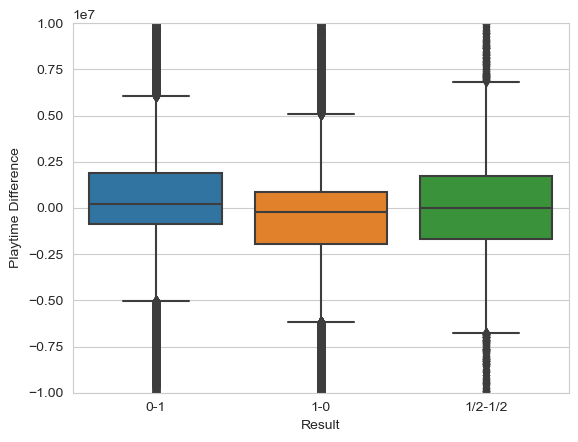

In [90]:
# create boxplot to explore difference between white and black victories with regard to difference in playtime
sns.set_style("whitegrid")
tips = sns.load_dataset("tips")
ax = sns.boxplot(x=data['Result'], y=data['Playtime Difference'])
ax.set_ylim(bottom = -10000000, top = 10000000)

(-30000.0, 30000.0)

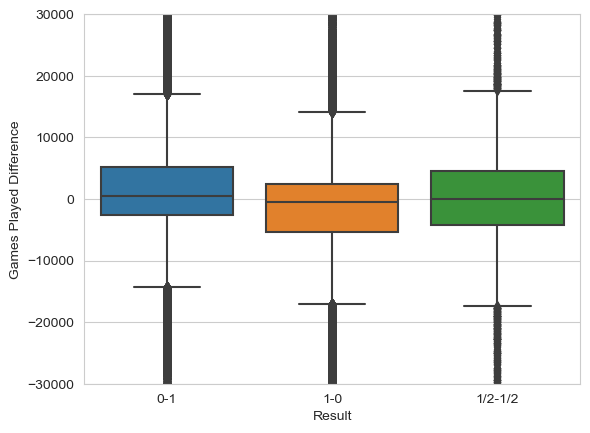

In [91]:
# create boxplot to explore difference between white and black victories with regard to number of games played
sns.set_style("whitegrid")
tips = sns.load_dataset("tips")
ax = sns.boxplot(x=data['Result'], y=data['Games Played Difference'])
ax.set_ylim(bottom = -30000, top = 30000)

(-200.0, 200.0)

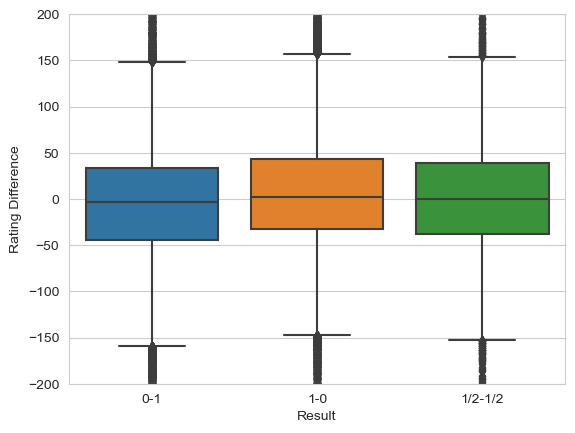

In [92]:
# create boxplot to explore difference between white and black victories with regard to difference in how the players are rated
sns.set_style("whitegrid")
tips = sns.load_dataset("tips")
ax = sns.boxplot(x=data['Result'], y=data['Rating Difference'])
ax.set_ylim(bottom = -200, top = 200)

(-600.0, 600.0)

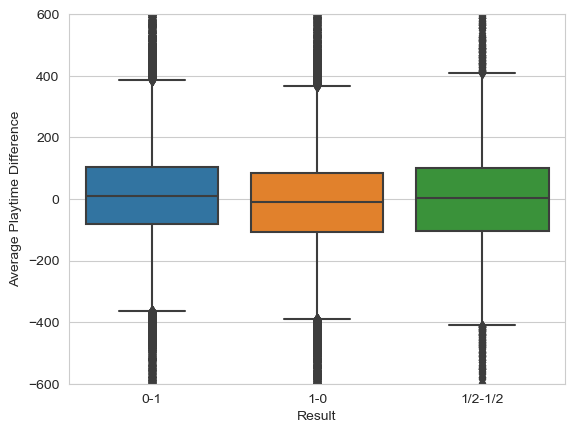

In [93]:
# create boxplot to explore difference between white and black victories with regard to average difference in playtime
sns.set_style("whitegrid")
tips = sns.load_dataset("tips")
ax = sns.boxplot(x=data['Result'], y=data['Average Playtime Difference'])
ax.set_ylim(bottom = -600, top = 600)

In [94]:
# drop features that are not categorical
data.drop(['WhiteElo','BlackElo','White_count_all','Black_count_all','White_playTime_total','Black_playTime_total'],axis=1,inplace=True)

In [95]:
# dummy encode the categorical data and sort into target and features
y = pd.get_dummies(data['Result'])
X = pd.get_dummies(data.drop('Result', axis=1))

In [96]:
# split the data into training and testing data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [97]:
from sklearn.preprocessing import StandardScaler
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Random Forest

In [34]:
# initiate a random forest model
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=512, random_state=78)

In [35]:
# train the model with training data
rf_model = rf_model.fit(X_train_scaled, y_train)

In [36]:
# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)

In [40]:
# Calculating the confusion matrix
from sklearn.metrics import accuracy_score, classification_report

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [42]:
# Displaying results
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions, target_names=['Black Wins', 'White Wins', 'Draw']))

Accuracy Score : 0.6016040227873078
Classification Report
              precision    recall  f1-score   support

  Black Wins       0.67      0.57      0.62     14516
  White Wins       0.68      0.67      0.67     15841
        Draw       0.00      0.00      0.00      1064

   micro avg       0.67      0.60      0.64     31421
   macro avg       0.45      0.41      0.43     31421
weighted avg       0.65      0.60      0.62     31421
 samples avg       0.60      0.60      0.60     31421



c:\Users\Ian\anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [43]:
# Random Forests in sklearn will automatically calculate feature importance
importances = rf_model.feature_importances_
# We can sort the features by their importance
sorted(zip(importances, X.columns), reverse=True)

[(0.19507156071721687, 'TotalMoves'),
 (0.14279263196713235, 'Playtime Difference'),
 (0.13946888783574055, 'Games Played Difference'),
 (0.132768463350627, 'Rating Difference'),
 (0.13144882239692643, 'Average Playtime Difference'),
 (0.12963849311032632, 'White Average Playtime'),
 (0.12881114062203056, 'Black Average Playtime')]

## Sequential NN Model

In [98]:
# Define the model - deep neural net
number_input_features = len(X_train.columns)

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=256, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=64, activation="relu"))

nn.add(tf.keras.layers.Dense(units=64, activation="relu"))

nn.add(tf.keras.layers.Dense(units=64, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=3, activation="softmax"))

# Check the structure of the model
nn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 256)               2048      
                                                                 
 dense_6 (Dense)             (None, 64)                16448     
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 64)                4160      
                                                                 
 dense_9 (Dense)             (None, 3)                 195       
                                                                 
Total params: 27011 (105.51 KB)
Trainable params: 27011 (105.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
nn.compile(loss="CategoricalCrossentropy", optimizer="adam", metrics=["accuracy"])

In [25]:
fit_model = nn.fit(X_train_scaled,y_train,epochs=100)

Epoch 1/100


2946/2946 [==============================] - 3s 775us/step - loss: 0.7831 - accuracy: 0.5560
Epoch 2/100
2946/2946 [==============================] - 2s 761us/step - loss: 0.7707 - accuracy: 0.5691
Epoch 3/100
2946/2946 [==============================] - 2s 758us/step - loss: 0.7674 - accuracy: 0.5745
Epoch 4/100
2946/2946 [==============================] - 2s 774us/step - loss: 0.7649 - accuracy: 0.5765
Epoch 5/100
2946/2946 [==============================] - 2s 770us/step - loss: 0.7623 - accuracy: 0.5799
Epoch 6/100
2946/2946 [==============================] - 2s 750us/step - loss: 0.7604 - accuracy: 0.5807
Epoch 7/100
2946/2946 [==============================] - 2s 754us/step - loss: 0.7592 - accuracy: 0.5827
Epoch 8/100
2946/2946 [==============================] - 2s 770us/step - loss: 0.7576 - accuracy: 0.5853
Epoch 9/100
2946/2946 [==============================] - 2s 747us/step - loss: 0.7564 - accuracy: 0.5851
Epoch 10/100
2946/2946 [=============================

KeyboardInterrupt: 

## Hyperparameter Tuning

In [102]:
# Create a method that creates a new Sequential model with hyperparameter options
def create_model(hp):
    nn_model = tf.keras.models.Sequential()

    # Allow kerastuner to decide which activation function to use in hidden layers
    activation = hp.Choice('activation',['relu','tanh','sigmoid','softmax','swish'])
    # Allow kerastuner to decide number of neurons in first layer
    nn_model.add(tf.keras.layers.Dense(units=hp.Int('first_units',
        min_value=1,
        max_value=512,
        step=5), activation=activation, input_dim=len(X_train.columns)))

    # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
    for i in range(hp.Int('num_layers', 1, 8)):
        nn_model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
            min_value=1,
            max_value=512,
            step=5),
            activation=activation))
    
    nn_model.add(tf.keras.layers.Dense(units=3, activation='softmax'))

    # Compile the model
    nn_model.compile(loss="CategoricalCrossentropy", optimizer='adam', metrics=["accuracy"])
    
    return nn_model

In [103]:
# Import the kerastuner library
import keras_tuner as kt

tuner = kt.Hyperband(
    create_model,
    objective="val_accuracy",
    max_epochs=20,
    hyperband_iterations=2,
    overwrite=True)

In [104]:
tuner.search(X_train_scaled,y_train,epochs=20,validation_data=(X_test_scaled,y_test))

Trial 60 Complete [00h 02m 14s]
val_accuracy: 0.576779842376709

Best val_accuracy So Far: 0.5794532299041748
Total elapsed time: 00h 43m 27s


In [106]:
top_hyper = tuner.get_best_hyperparameters(3)
for param in top_hyper:
    print(param.values)

{'activation': 'swish', 'first_units': 366, 'num_layers': 5, 'units_0': 111, 'units_1': 126, 'units_2': 311, 'units_3': 41, 'units_4': 351, 'units_5': 426, 'units_6': 466, 'units_7': 321, 'tuner/epochs': 20, 'tuner/initial_epoch': 7, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0018'}
{'activation': 'relu', 'first_units': 406, 'num_layers': 8, 'units_0': 141, 'units_1': 111, 'units_2': 436, 'units_3': 186, 'units_4': 206, 'units_5': 61, 'units_6': 251, 'units_7': 501, 'tuner/epochs': 20, 'tuner/initial_epoch': 7, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0052'}
{'activation': 'relu', 'first_units': 316, 'num_layers': 7, 'units_0': 371, 'units_1': 261, 'units_2': 316, 'units_3': 481, 'units_4': 151, 'units_5': 381, 'units_6': 51, 'units_7': 496, 'tuner/epochs': 7, 'tuner/initial_epoch': 0, 'tuner/bracket': 1, 'tuner/round': 0}


In [107]:
best_model = tuner.get_best_models()[0]
model_loss, model_accuracy = best_model.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

982/982 - 1s - loss: 0.7681 - accuracy: 0.5795 - 1s/epoch - 1ms/step
Loss: 0.7680790424346924, Accuracy: 0.5794532299041748


## Binning Outliers in Rating Difference

In [108]:
bins = [-2000, -1000, -500, -150, -50, 0, 50, 150, 500, 1000, 2000]
data['Rating Difference'] = pd.cut(data['Rating Difference'], bins)

TypeError: '<' not supported between instances of 'int' and 'pandas._libs.interval.Interval'

In [109]:
data['Rating Difference'].head()

0      (50, 150]
1    (-150, -50]
2       (-50, 0]
3       (-50, 0]
4       (-50, 0]
Name: Rating Difference, dtype: category
Categories (10, interval[int64, right]): [(-2000, -1000] < (-1000, -500] < (-500, -150] < (-150, -50] ... (50, 150] < (150, 500] < (500, 1000] < (1000, 2000]]

In [66]:
# dummy encode the categorical data and sort into target and features
y = pd.get_dummies(data['Result'])
X = pd.get_dummies(data.drop('Result', axis=1))

In [67]:
# split the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [68]:
from sklearn.preprocessing import StandardScaler
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [69]:
# initiate a random forest model
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=512, random_state=78)

In [70]:
# train the model with training data
rf_model = rf_model.fit(X_train_scaled, y_train)

In [71]:
# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)

In [72]:
# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [73]:
# Displaying results
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions, target_names=['Black Wins', 'White Wins', 'Draw']))

Accuracy Score : 0.5837497215238217
Classification Report
              precision    recall  f1-score   support

  Black Wins       0.65      0.55      0.60     14516
  White Wins       0.66      0.65      0.65     15841
        Draw       0.00      0.00      0.00      1064

   micro avg       0.65      0.58      0.62     31421
   macro avg       0.43      0.40      0.42     31421
weighted avg       0.63      0.58      0.61     31421
 samples avg       0.58      0.58      0.58     31421



c:\Users\Ian\anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [74]:
# Calculating feature importance
importances = rf_model.feature_importances_
# We can sort the features by their importance
sorted(zip(importances, X.columns), reverse=True)

[(0.20417716258915353, 'TotalMoves'),
 (0.16008715376553523, 'Playtime Difference'),
 (0.15679306866432044, 'Games Played Difference'),
 (0.14858828998382126, 'Average Playtime Difference'),
 (0.14661640016872798, 'White Average Playtime'),
 (0.14642235984674798, 'Black Average Playtime'),
 (0.007563483583772837, 'Rating Difference_(-50, 0]'),
 (0.00738571955451873, 'Rating Difference_(0, 50]'),
 (0.005389051272143455, 'Rating Difference_(-150, -50]'),
 (0.004439173176373118, 'Rating Difference_(-500, -150]'),
 (0.004362699279370156, 'Rating Difference_(150, 500]'),
 (0.004288556761098735, 'Rating Difference_(50, 150]'),
 (0.0016191535146478657, 'Rating Difference_(500, 1000]'),
 (0.0016089741538236977, 'Rating Difference_(-1000, -500]'),
 (0.0004122208829182406, 'Rating Difference_(-2000, -1000]'),
 (0.0002465328030266965, 'Rating Difference_(1000, 2000]')]

In [110]:
# Define the model - deep neural net
number_input_features = len(X_train.columns)

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=256, input_dim=number_input_features, activation="mish")
)

# Further hidden layers
nn.add(tf.keras.layers.Dense(units=64, activation="mish"))

nn.add(tf.keras.layers.Dense(units=64, activation="mish"))

nn.add(tf.keras.layers.Dense(units=64, activation="mish"))

# Output layer
nn.add(tf.keras.layers.Dense(units=3, activation="softmax"))

# Check the structure of the model
nn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 256)               2048      
                                                                 
 dense_11 (Dense)            (None, 64)                16448     
                                                                 
 dense_12 (Dense)            (None, 64)                4160      
                                                                 
 dense_13 (Dense)            (None, 64)                4160      
                                                                 
 dense_14 (Dense)            (None, 3)                 195       
                                                                 
Total params: 27011 (105.51 KB)
Trainable params: 27011 (105.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [111]:
nn.compile(loss="CategoricalCrossentropy", optimizer="adam", metrics=["accuracy"])

In [112]:
fit_model = nn.fit(X_train_scaled,y_train,epochs=100)

Epoch 1/100
2946/2946 [==============================] - 3s 895us/step - loss: 0.7889 - accuracy: 0.5450
Epoch 2/100
2946/2946 [==============================] - 3s 891us/step - loss: 0.7798 - accuracy: 0.5578
Epoch 3/100
2946/2946 [==============================] - 3s 880us/step - loss: 0.7774 - accuracy: 0.5626
Epoch 4/100
2946/2946 [==============================] - 3s 865us/step - loss: 0.7754 - accuracy: 0.5653
Epoch 5/100
2946/2946 [==============================] - 3s 858us/step - loss: 0.7742 - accuracy: 0.5702
Epoch 6/100
2946/2946 [==============================] - 3s 856us/step - loss: 0.7733 - accuracy: 0.5692
Epoch 7/100
2946/2946 [==============================] - 3s 852us/step - loss: 0.7726 - accuracy: 0.5718
Epoch 8/100
2946/2946 [==============================] - 2s 846us/step - loss: 0.7718 - accuracy: 0.5716
Epoch 9/100
2946/2946 [==============================] - 3s 850us/step - loss: 0.7714 - accuracy: 0.5729
Epoch 10/100
2946/2946 [==============================]

## Dropping Outliers

In [121]:
# select relevant columns of data and save as pandas dataframe
data = spark.sql(
    '''
SELECT WhiteElo, White_playTime_total, White_count_all, BlackElo, Black_playTime_total, Black_count_all, TotalMoves,
Result from chess
WHERE Result != '*'
'''
).toPandas()

In [122]:
# drop null values
data.dropna(inplace=True)

In [123]:
# create features exploring the differences in white versus black to use in prediction model
data['Rating Difference'] = data['WhiteElo'] - data['BlackElo']
data['Playtime Difference'] = data['White_playTime_total'] - data['Black_playTime_total']
data['Games Played Difference'] = data['White_count_all'] - data['Black_count_all']
data['White Average Playtime'] = data['White_playTime_total']/data['White_count_all']
data['Black Average Playtime'] = data['Black_playTime_total']/data['Black_count_all']
data['Average Playtime Difference'] = data['White Average Playtime'] - data['Black Average Playtime']

In [124]:
# drop features that are not categorical
data.drop(['WhiteElo','BlackElo','White_count_all','Black_count_all','White_playTime_total','Black_playTime_total'],axis=1,inplace=True)

In [126]:
indices = data.loc[(data['Rating Difference']>150) | (data['Rating Difference'] < -150)].index
data.drop(indices, inplace=True)

In [127]:
# dummy encode the categorical data and sort into target and features
y = pd.get_dummies(data['Result'])
X = pd.get_dummies(data.drop('Result', axis=1))

In [128]:
# split the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [129]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [130]:
# initiate a random forest model
rf_model = RandomForestClassifier(n_estimators=512, random_state=78)

In [153]:
# train the model with training data
rf_model = rf_model.fit(X_train_scaled, y_train)

In [154]:
# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)

In [155]:
# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [156]:
# Displaying results
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions, target_names=['Black Wins', 'White Wins', 'Draw']))

Accuracy Score : 0.5814647118010636
Classification Report
              precision    recall  f1-score   support

  Black Wins       0.65      0.55      0.60     12913
  White Wins       0.66      0.65      0.66     13906
        Draw       0.00      0.00      0.00      1009

   micro avg       0.66      0.58      0.62     27828
   macro avg       0.44      0.40      0.42     27828
weighted avg       0.63      0.58      0.60     27828
 samples avg       0.58      0.58      0.58     27828



c:\Users\Ian\anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Random Forests in sklearn will automatically calculate feature importance
importances = rf_model.feature_importances_
# We can sort the features by their importance
sorted(zip(importances, X.columns), reverse=True)

[(0.19507156071721687, 'TotalMoves'),
 (0.14279263196713235, 'Playtime Difference'),
 (0.13946888783574055, 'Games Played Difference'),
 (0.132768463350627, 'Rating Difference'),
 (0.13144882239692643, 'Average Playtime Difference'),
 (0.12963849311032632, 'White Average Playtime'),
 (0.12881114062203056, 'Black Average Playtime')]

In [137]:
# Define the model - deep neural net
number_input_features = len(X_train.columns)

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=256, input_dim=number_input_features, activation="mish")
)

# Further hidden layers
nn.add(tf.keras.layers.Dense(units=64, activation="mish"))

nn.add(tf.keras.layers.Dense(units=64, activation="mish"))

nn.add(tf.keras.layers.Dense(units=64, activation="mish"))

# Output layer
nn.add(tf.keras.layers.Dense(units=3, activation="softmax"))

# Check the structure of the model
nn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 256)               2048      
                                                                 
 dense_21 (Dense)            (None, 64)                16448     
                                                                 
 dense_22 (Dense)            (None, 64)                4160      
                                                                 
 dense_23 (Dense)            (None, 64)                4160      
                                                                 
 dense_24 (Dense)            (None, 3)                 195       
                                                                 
Total params: 27011 (105.51 KB)
Trainable params: 27011 (105.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [144]:
nn.compile(loss="CategoricalCrossentropy", optimizer="adam", metrics=["accuracy"])

In [146]:
fit_model = nn.fit(X_train_scaled,y_train,epochs=20,validation_data=(X_test_scaled,y_test))

Epoch 1/20
2609/2609 [==============================] - 3s 1ms/step - loss: 0.7727 - accuracy: 0.5722 - val_loss: 0.7766 - val_accuracy: 0.5640
Epoch 2/20
2609/2609 [==============================] - 3s 1ms/step - loss: 0.7722 - accuracy: 0.5719 - val_loss: 0.7778 - val_accuracy: 0.5650
Epoch 3/20
2609/2609 [==============================] - 3s 1ms/step - loss: 0.7722 - accuracy: 0.5727 - val_loss: 0.7759 - val_accuracy: 0.5670
Epoch 4/20
2609/2609 [==============================] - 3s 1ms/step - loss: 0.7717 - accuracy: 0.5728 - val_loss: 0.7763 - val_accuracy: 0.5685
Epoch 5/20
2609/2609 [==============================] - 3s 1ms/step - loss: 0.7713 - accuracy: 0.5725 - val_loss: 0.7765 - val_accuracy: 0.5686
Epoch 6/20
2609/2609 [==============================] - 3s 1ms/step - loss: 0.7710 - accuracy: 0.5736 - val_loss: 0.7756 - val_accuracy: 0.5691
Epoch 7/20
2609/2609 [==============================] - 3s 1ms/step - loss: 0.7709 - accuracy: 0.5745 - val_loss: 0.7762 - val_accuracy:

## Adding a Dropout Layer

In [147]:
# Define the model - deep neural net
number_input_features = len(X_train.columns)

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=256, input_dim=number_input_features, activation="mish")
)

# Further hidden layers
nn.add(tf.keras.layers.Dense(units=64, activation="mish"))

# Adding dropout layer

nn.add(tf.keras.layers.Dropout(0.1))

# More hidden layers

nn.add(tf.keras.layers.Dense(units=64, activation="mish"))

nn.add(tf.keras.layers.Dense(units=64, activation="mish"))

# Output layer
nn.add(tf.keras.layers.Dense(units=3, activation="softmax"))

# Check the structure of the model
nn.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 256)               2048      
                                                                 
 dense_26 (Dense)            (None, 64)                16448     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_27 (Dense)            (None, 64)                4160      
                                                                 
 dense_28 (Dense)            (None, 64)                4160      
                                                                 
 dense_29 (Dense)            (None, 3)                 195       
                                                                 
Total params: 27011 (105.51 KB)
Trainable params: 2701

In [148]:
nn.compile(loss="CategoricalCrossentropy", optimizer="adam", metrics=["accuracy"])

In [149]:
fit_model = nn.fit(X_train_scaled,y_train,epochs=20,validation_data=(X_test_scaled,y_test))

Epoch 1/20
2609/2609 [==============================] - 4s 1ms/step - loss: 0.7913 - accuracy: 0.5447 - val_loss: 0.7870 - val_accuracy: 0.5442
Epoch 2/20
2609/2609 [==============================] - 3s 1ms/step - loss: 0.7831 - accuracy: 0.5573 - val_loss: 0.7797 - val_accuracy: 0.5622
Epoch 3/20
2609/2609 [==============================] - 3s 1ms/step - loss: 0.7806 - accuracy: 0.5592 - val_loss: 0.7768 - val_accuracy: 0.5663
Epoch 4/20
2609/2609 [==============================] - 3s 1ms/step - loss: 0.7790 - accuracy: 0.5627 - val_loss: 0.7806 - val_accuracy: 0.5670
Epoch 5/20
2609/2609 [==============================] - 3s 1ms/step - loss: 0.7779 - accuracy: 0.5656 - val_loss: 0.7800 - val_accuracy: 0.5664
Epoch 6/20
2609/2609 [==============================] - 3s 1ms/step - loss: 0.7778 - accuracy: 0.5649 - val_loss: 0.7780 - val_accuracy: 0.5660
Epoch 7/20
2609/2609 [==============================] - 3s 1ms/step - loss: 0.7770 - accuracy: 0.5675 - val_loss: 0.7775 - val_accuracy:

## Adding a Normalization Layer

In [160]:
# Define the model - deep neural net
number_input_features = len(X_train.columns)

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=256, input_dim=number_input_features, activation="relu")
)

# Further hidden layers
nn.add(tf.keras.layers.Dense(units=64, activation="relu"))

nn.add(tf.keras.layers.Normalization(axis=None))

nn.add(tf.keras.layers.Dense(units=64, activation="relu"))

nn.add(tf.keras.layers.Dense(units=64, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=3, activation="softmax"))

# Check the structure of the model
nn.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_35 (Dense)            (None, 256)               2048      
                                                                 
 dense_36 (Dense)            (None, 64)                16448     
                                                                 
 normalization_1 (Normaliza  (None, 64)                3         
 tion)                                                           
                                                                 
 dense_37 (Dense)            (None, 64)                4160      
                                                                 
 dense_38 (Dense)            (None, 64)                4160      
                                                                 
 dense_39 (Dense)            (None, 3)                 195       
                                                      

In [161]:
nn.compile(loss="CategoricalCrossentropy", optimizer="adam", metrics=["accuracy"])

In [162]:
fit_model = nn.fit(X_train_scaled,y_train,epochs=20,validation_data=(X_test_scaled,y_test))

Epoch 1/20
2609/2609 [==============================] - 3s 1ms/step - loss: 0.7900 - accuracy: 0.5489 - val_loss: 0.7803 - val_accuracy: 0.5563
Epoch 2/20
2609/2609 [==============================] - 3s 958us/step - loss: 0.7805 - accuracy: 0.5609 - val_loss: 0.7777 - val_accuracy: 0.5622
Epoch 3/20
2609/2609 [==============================] - 3s 965us/step - loss: 0.7781 - accuracy: 0.5646 - val_loss: 0.7783 - val_accuracy: 0.5646
Epoch 4/20
2609/2609 [==============================] - 3s 962us/step - loss: 0.7771 - accuracy: 0.5666 - val_loss: 0.7784 - val_accuracy: 0.5648
Epoch 5/20
2609/2609 [==============================] - 3s 1ms/step - loss: 0.7756 - accuracy: 0.5695 - val_loss: 0.7786 - val_accuracy: 0.5657
Epoch 6/20
2590/2609 [============================>.] - ETA: 0s - loss: 0.7750 - accuracy: 0.5714

KeyboardInterrupt: 

## XGBoost

In [179]:
# dummy encode the categorical data and sort into target and features
resultmap = {'0-1':0, '1-0':1, '1/2-1/2':2}
y = data['Result'].map(resultmap)
X = pd.get_dummies(data.drop('Result', axis=1))

In [180]:
# split the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [181]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [207]:
from xgboost import XGBClassifier
xg_nn = XGBClassifier(n_estimators = 256, max_depth = 32, objective ='multi:softmax')
xg_nn.fit(X_train_scaled,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=32, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=256, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [208]:
predictions = xg_nn.predict(X_test_scaled)

In [209]:
accuracy_score(y_test, predictions)

0.9002443582003737

In [210]:
print(classification_report(y_test, predictions, target_names=['Black Wins', 'White Wins', 'Draw']))

              precision    recall  f1-score   support

  Black Wins       0.90      0.93      0.91     12913
  White Wins       0.91      0.93      0.92     13906
        Draw       0.24      0.03      0.06      1009

    accuracy                           0.90     27828
   macro avg       0.68      0.63      0.63     27828
weighted avg       0.88      0.90      0.89     27828



In [206]:
from sklearn.metrics import confusion_matrix
cm_df = pd.DataFrame(confusion_matrix(y_test, predictions,))

[Text(0, 0.5, 'Black Wins'), Text(0, 1.5, 'White Wins'), Text(0, 2.5, 'Draw')]

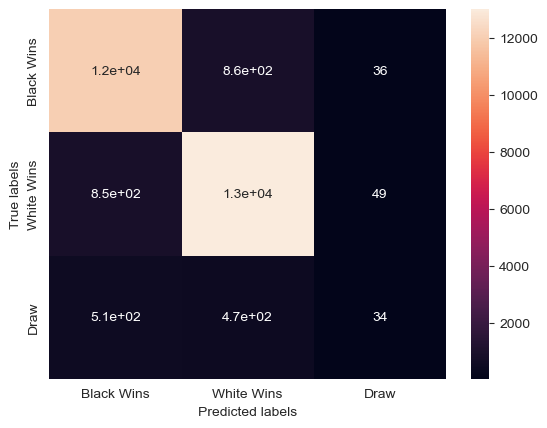

In [205]:
ax = sns.heatmap(cm_df,annot=True)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.xaxis.set_ticklabels(['Black Wins', 'White Wins', 'Draw']); ax.yaxis.set_ticklabels(['Black Wins', 'White Wins', 'Draw'])